In [1]:
from datetime import datetime

import incense
import matplotlib.pyplot as plt
import numpy as np
from incense import ExperimentLoader


In [2]:
def get_permutation(step, length=24):
    np.random.seed(42)
    block_permutation = np.random.permutation(step)
    # ensure that number of inversions is about half
    while True:
        inversions = sum(
            (block_permutation[i] > block_permutation[j])
            for i in range(step)
            for j in range(i + 1, step)
        )
        max_inv = step * (step - 1) // 2
        l = int(np.ceil(0.4 * max_inv))
        r = max(l + 1, int(0.6 * max_inv))
        if l <= inversions <= r:
            break
        block_permutation = np.random.permutation(step)
    result = np.arange(length)
    for i in range(0, length, step):
        current_block = result[i : i + step].copy()
        result[i : i + step] = current_block[block_permutation]
    return result.tolist()


def infer_step(permutation):
    if not isinstance(permutation, str):
        return None
    permutation = eval(permutation)
    if not isinstance(permutation, list):
        return None
    if len(permutation) != 24:
        return None
    for step in range(1, len(permutation)):
        if len(permutation) % step == 0:
            check = get_permutation(step)
            if permutation == check:
                return step
    raise ValueError("No step found")


In [32]:
from typing import Any

import neptune

neptune_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NTIzY2UxZC1jMjI5LTRlYTQtYjQ0Yi1kM2JhMGU1NDllYTIifQ=="
project = neptune.init_project(project="GUD", api_token=neptune_token, mode="read-only")
columns = [
    "sys/id",
    "experiment/metrics/train_loss",
    "experiment/metrics/val_loss",
    "experiment/metrics/validation_q50",
    "experiment/config/diffusion_config window",
    "experiment/config/generator_config permutation",
    "experiment/config/comment",
]
runs = project.fetch_runs_table().to_pandas()
project.stop()


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mlxa/GUD/


Fetching table...: 0 [00:00, ?/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/mlxa/GUD/metadata


In [33]:
selected = runs[columns].copy()
selected.columns = [
    "id",
    "train_loss",
    "val_loss",
    "metric",
    "window",
    "permutation",
    "comment",
]
selected["step"] = selected["permutation"].apply(lambda p: infer_step(p))
selected["id"] = selected["id"].apply(lambda x: int(x.split("-")[-1]))
selected = selected.dropna()
# selected = selected[selected["id"] <= 1124]
selected = selected[selected["comment"].str.contains("permutation-grid", na=False)]
selected["window"] = np.clip(selected["window"], 1, 100)
# TODO: take something with less variance than last value of loss


In [34]:
selected


,id,train_loss,val_loss,metric,window,permutation,comment,step
0,1136,100.671045,139.013037,0.047652,8.0,"[1, 3, 0, 2, 5, 7, 4, 6, 9, 11, 8, 10, 13, 15,...",w=8 step=4 l=mask_dsnr | permutation-grid,4.0
1,1135,106.976867,123.988623,0.073946,8.0,"[1, 3, 0, 2, 5, 7, 4, 6, 9, 11, 8, 10, 13, 15,...",w=8 step=4 l=mask_dsnr | permutation-grid,4.0
2,1134,55.418828,214.982500,0.018909,2.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",w=2 step=1 l=mask_dsnr | permutation-grid,1.0
3,1133,44.840964,179.920923,0.023136,2.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",w=2 step=1 l=mask_dsnr | permutation-grid,1.0
4,1132,73.294787,174.737422,0.022449,4.0,"[1, 3, 0, 2, 5, 7, 4, 6, 9, 11, 8, 10, 13, 15,...",w=4 step=4 l=mask_dsnr | permutation-grid,4.0
...,...,...,...,...,...,...,...,...
217,919,97.053416,167.517921,0.044664,2.0,"[10, 9, 0, 8, 5, 2, 1, 11, 4, 7, 3, 6, 22, 21,...",w=2 step=12 l=mask_dsnr | permutation-grid,12.0
218,918,102.729322,189.901120,0.075555,1.0,"[10, 9, 0, 8, 5, 2, 1, 11, 4, 7, 3, 6, 22, 21,...",w=1 step=12 l=mask_dsnr | permutation-grid,12.0
220,916,86.339955,163.479478,0.035713,1.0,"[10, 9, 0, 8, 5, 2, 1, 11, 4, 7, 3, 6, 22, 21,...",w=1 step=12 l=mask_dsnr | permutation-grid,12.0
222,914,94.763414,115.646043,0.058773,1.0,"[10, 9, 0, 8, 5, 2, 1, 11, 4, 7, 3, 6, 22, 21,...",w=1 step=12 l=mask_dsnr | permutation-grid,12.0


In [14]:
from collections import defaultdict

error_lists = defaultdict(list)
loss_lists = defaultdict(list)
val_lists = defaultdict(list)
for _, exp in selected.iterrows():
    step, w = exp["step"], exp["window"]
    error_lists[(step, w)].append(exp["metric"])
    loss_lists[(step, w)].append(exp["train_loss"])
    val_lists[(step, w)].append(exp["val_loss"])
print(str(error_lists)[:200])
print(str(loss_lists)[:200])
print(str(val_lists)[:200])


defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})


In [15]:
# loader = ExperimentLoader(db_name="sacred")
# exp = loader.find_by_id(2712)
# exp.config["train_config"]["output_path"]
# from collections import defaultdict
# from pprint import pprint

# error_lists = defaultdict(list)
# loss_lists = defaultdict(list)
# names = ["mnist-3"]

# for exp in loader.find_all():
#     if "comment" not in exp.meta:
#         print("no comment in ", exp.id)
#         continue
#     notes = exp.meta["comment"]
#     if not any(name in notes for name in names):
#         continue

#     try:
#         params = parse_params(notes)
#         step = params["step"]
#         w = params.get("w", None)
#         if params["k"] == "AR":
#             w = 1
#         elif params["k"] == "D":
#             w = 256
#         value = min(exp.metrics["q50"])
#         loss = min(exp.metrics["loss"][-30:])
#         # loss = np.median(exp.metrics["loss"][-30:])
#         print(f"#{exp.id} {step} {w}: {value} {loss}")
#         error_lists[(step, w)].append(value)
#         loss_lists[(step, w)].append(loss)
#     except Exception:
#         continue


/var/folders/sm/c_cj474n2sngck2h4fsn34gw0000gn/T/ipykernel_95845/1792625885.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


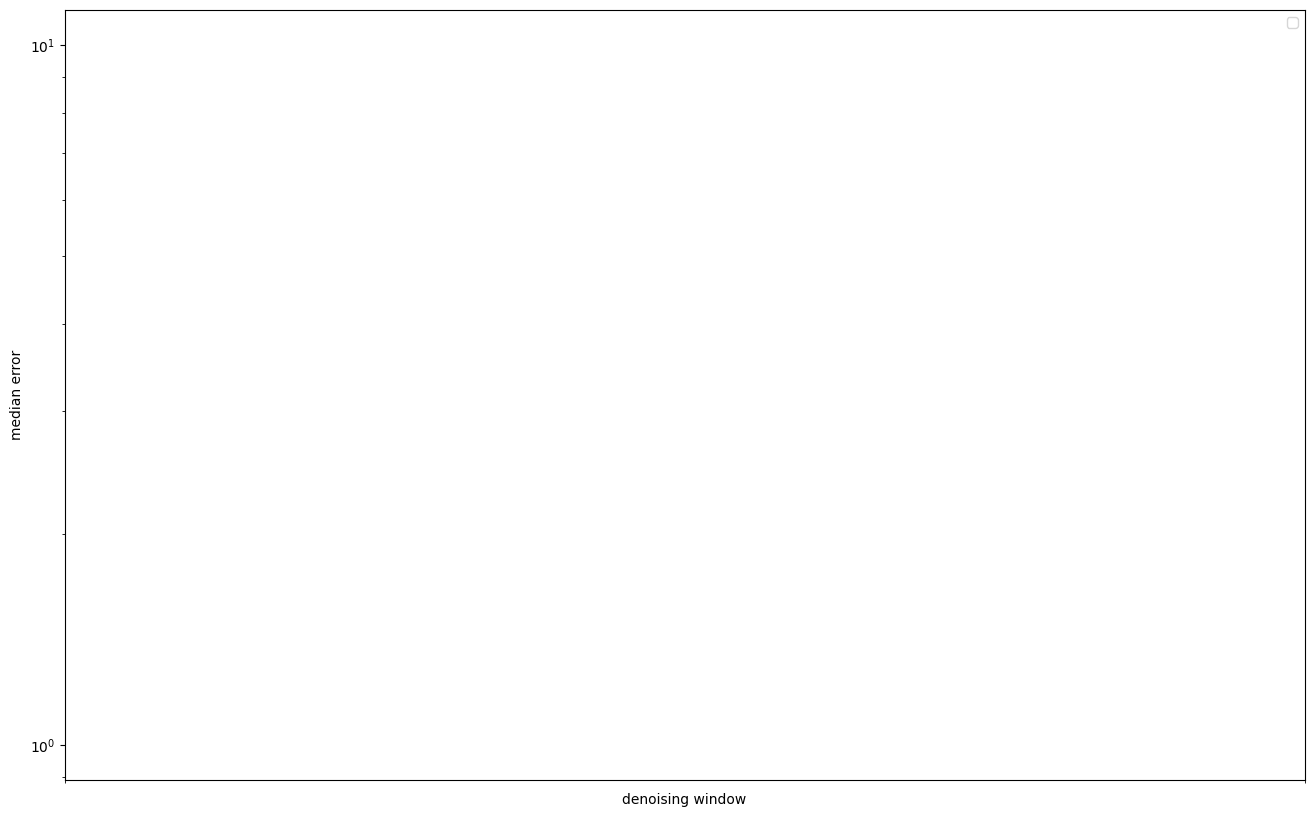

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))

for step, color in zip(steps, colors):
    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = error_lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(np.log(cur)))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    # means = gaussian_filter1d(means, sigma=0.01)
    # stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    # Apply std band in log space
    plt.fill_between(
        xs, means / np.exp(stds), means * np.exp(stds), alpha=0.05, color=color
    )

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.yscale("log")
plt.legend()
plt.show()


/var/folders/sm/c_cj474n2sngck2h4fsn34gw0000gn/T/ipykernel_95845/3090220690.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


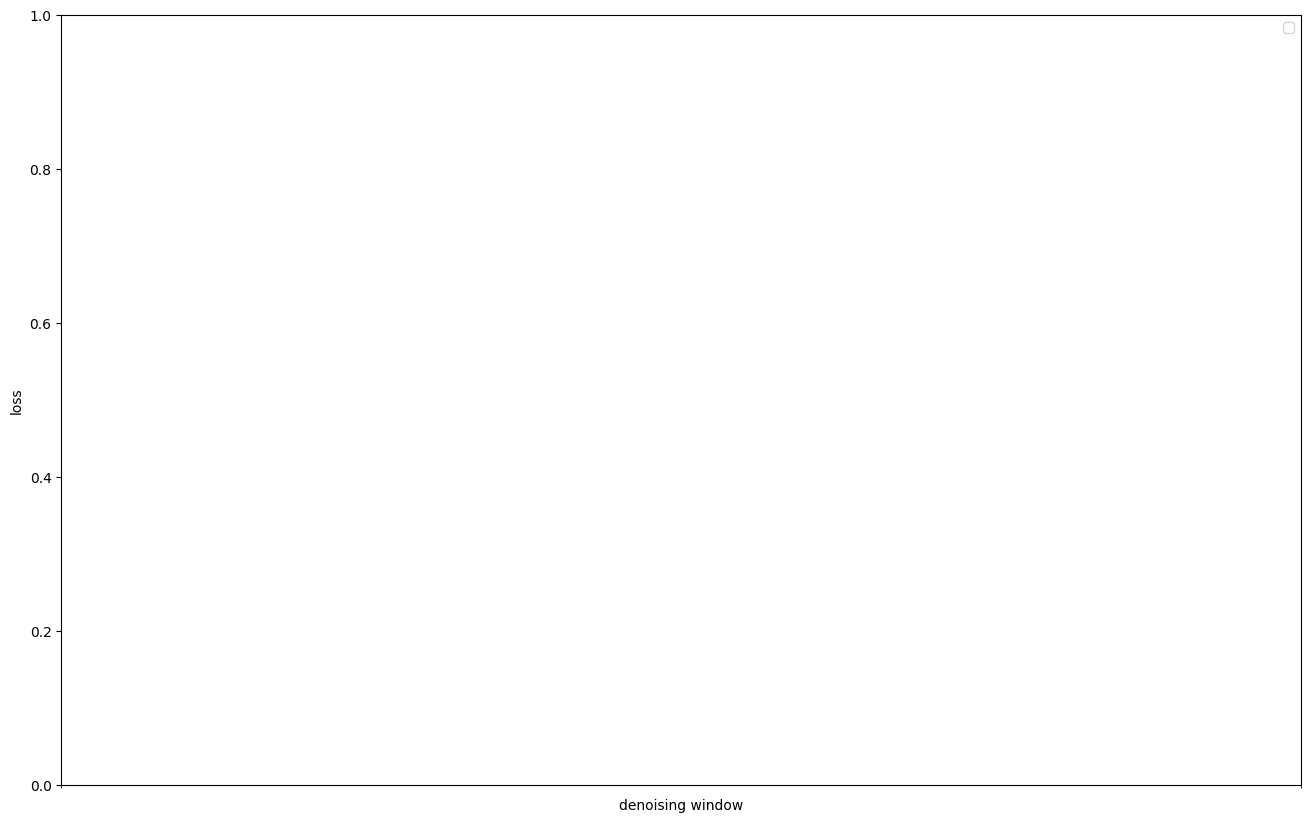

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))


for step, color in zip(steps, colors):
    means, stds, xs = [], [], []
    for w in ws:
        cur = loss_lists[(step, w)]
        # cur = [x for x in cur if x < 0.6]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    # means = gaussian_filter1d(means, sigma=0.01)
    # stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("loss")
plt.legend()
plt.show()


/var/folders/sm/c_cj474n2sngck2h4fsn34gw0000gn/T/ipykernel_95845/1773873536.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


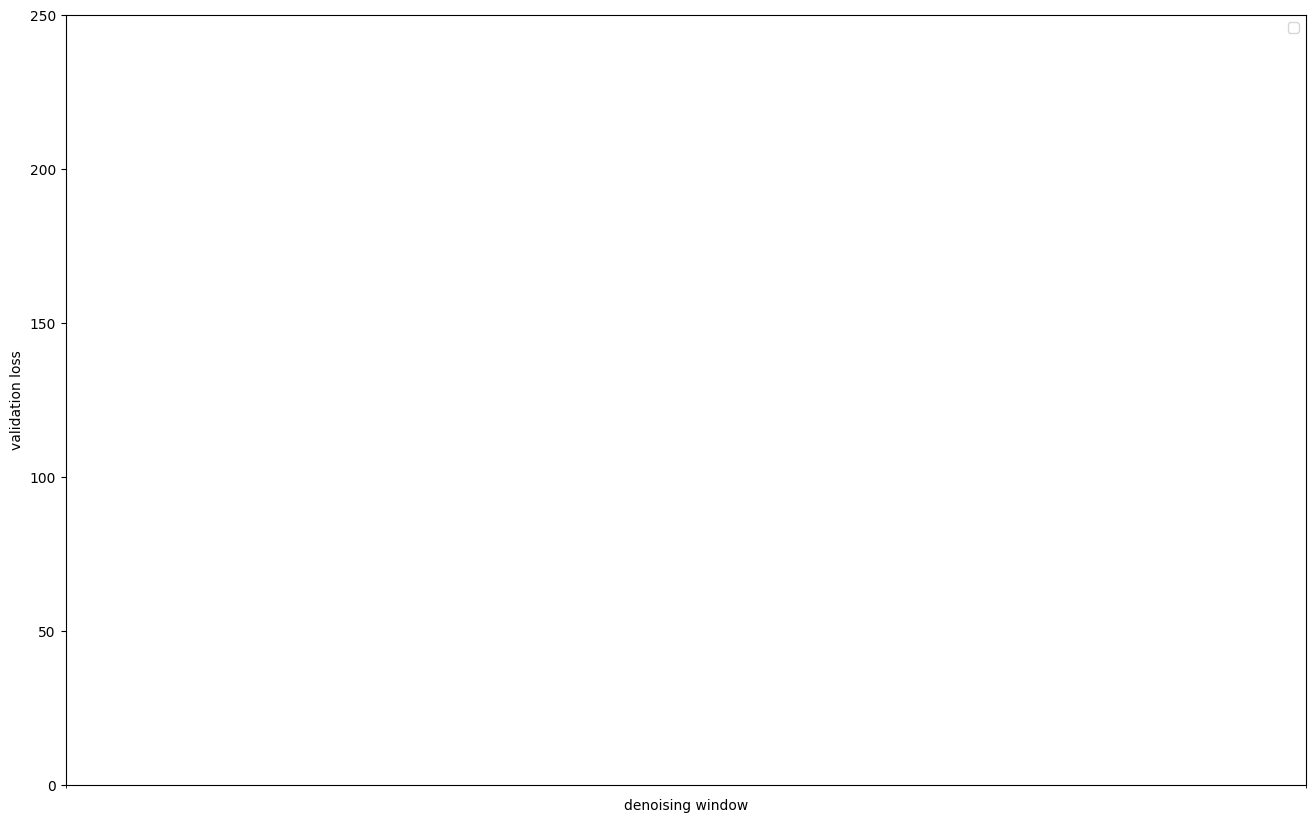

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.1, 0.9, len(steps)))


for step, color in zip(steps, colors):
    means, stds, xs = [], [], []
    for w in ws:
        cur = val_lists[(step, w)]
        # cur = [x for x in cur if x < 0.6]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            plt.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    # Smooth means and stds with gaussian filter
    from scipy.ndimage import gaussian_filter1d

    # means = gaussian_filter1d(means, sigma=0.01)
    # stds = gaussian_filter1d(stds, sigma=1.0)
    xs = np.array(xs)

    # Plot mean line and std area
    plt.plot(xs, means, "-", label=f"step={step}", color=color)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.ylim(0, 250)
plt.xlabel("denoising window")
plt.ylabel("validation loss")
plt.legend()
plt.show()


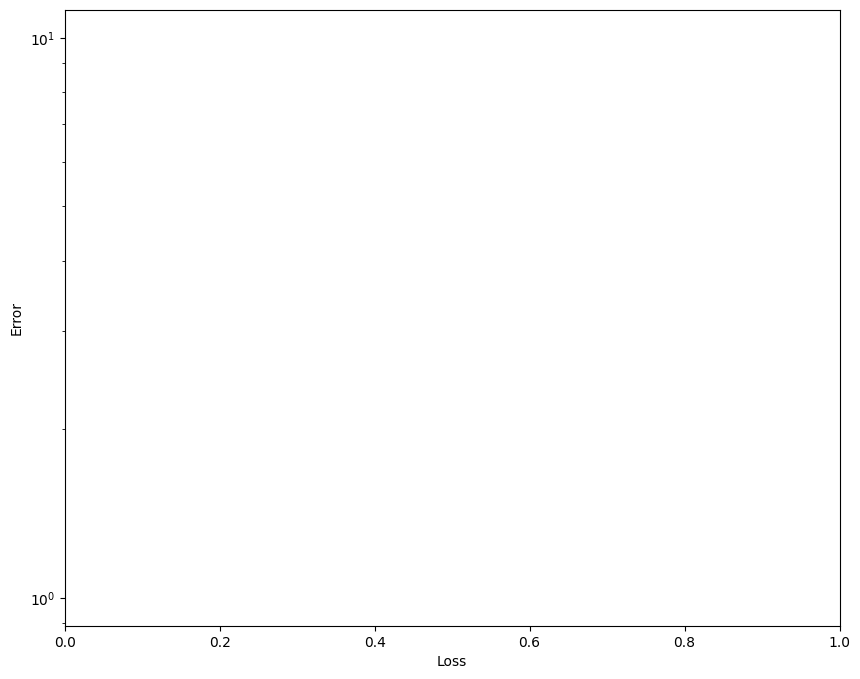

In [19]:
plt.figure(figsize=(10, 8))

# Create scatter plot of loss vs error
for step in steps:
    print(step)
    xs, ys = [], []  # losses and errors
    for w in ws:
        if (step, w) in loss_lists and (step, w) in error_lists:
            losses = loss_lists[(step, w)]
            errors = error_lists[(step, w)]
            if len(losses) == len(errors):
                # Color based on window size w
                color = plt.cm.viridis(np.log(step) / np.log(max(steps)))
                plt.scatter(
                    losses,
                    errors,
                    c=[color] * len(losses),
                    alpha=0.5,
                )

# plt.colorbar()
plt.yscale("log")
plt.xlabel("Loss")
plt.ylabel("Error")
plt.show()


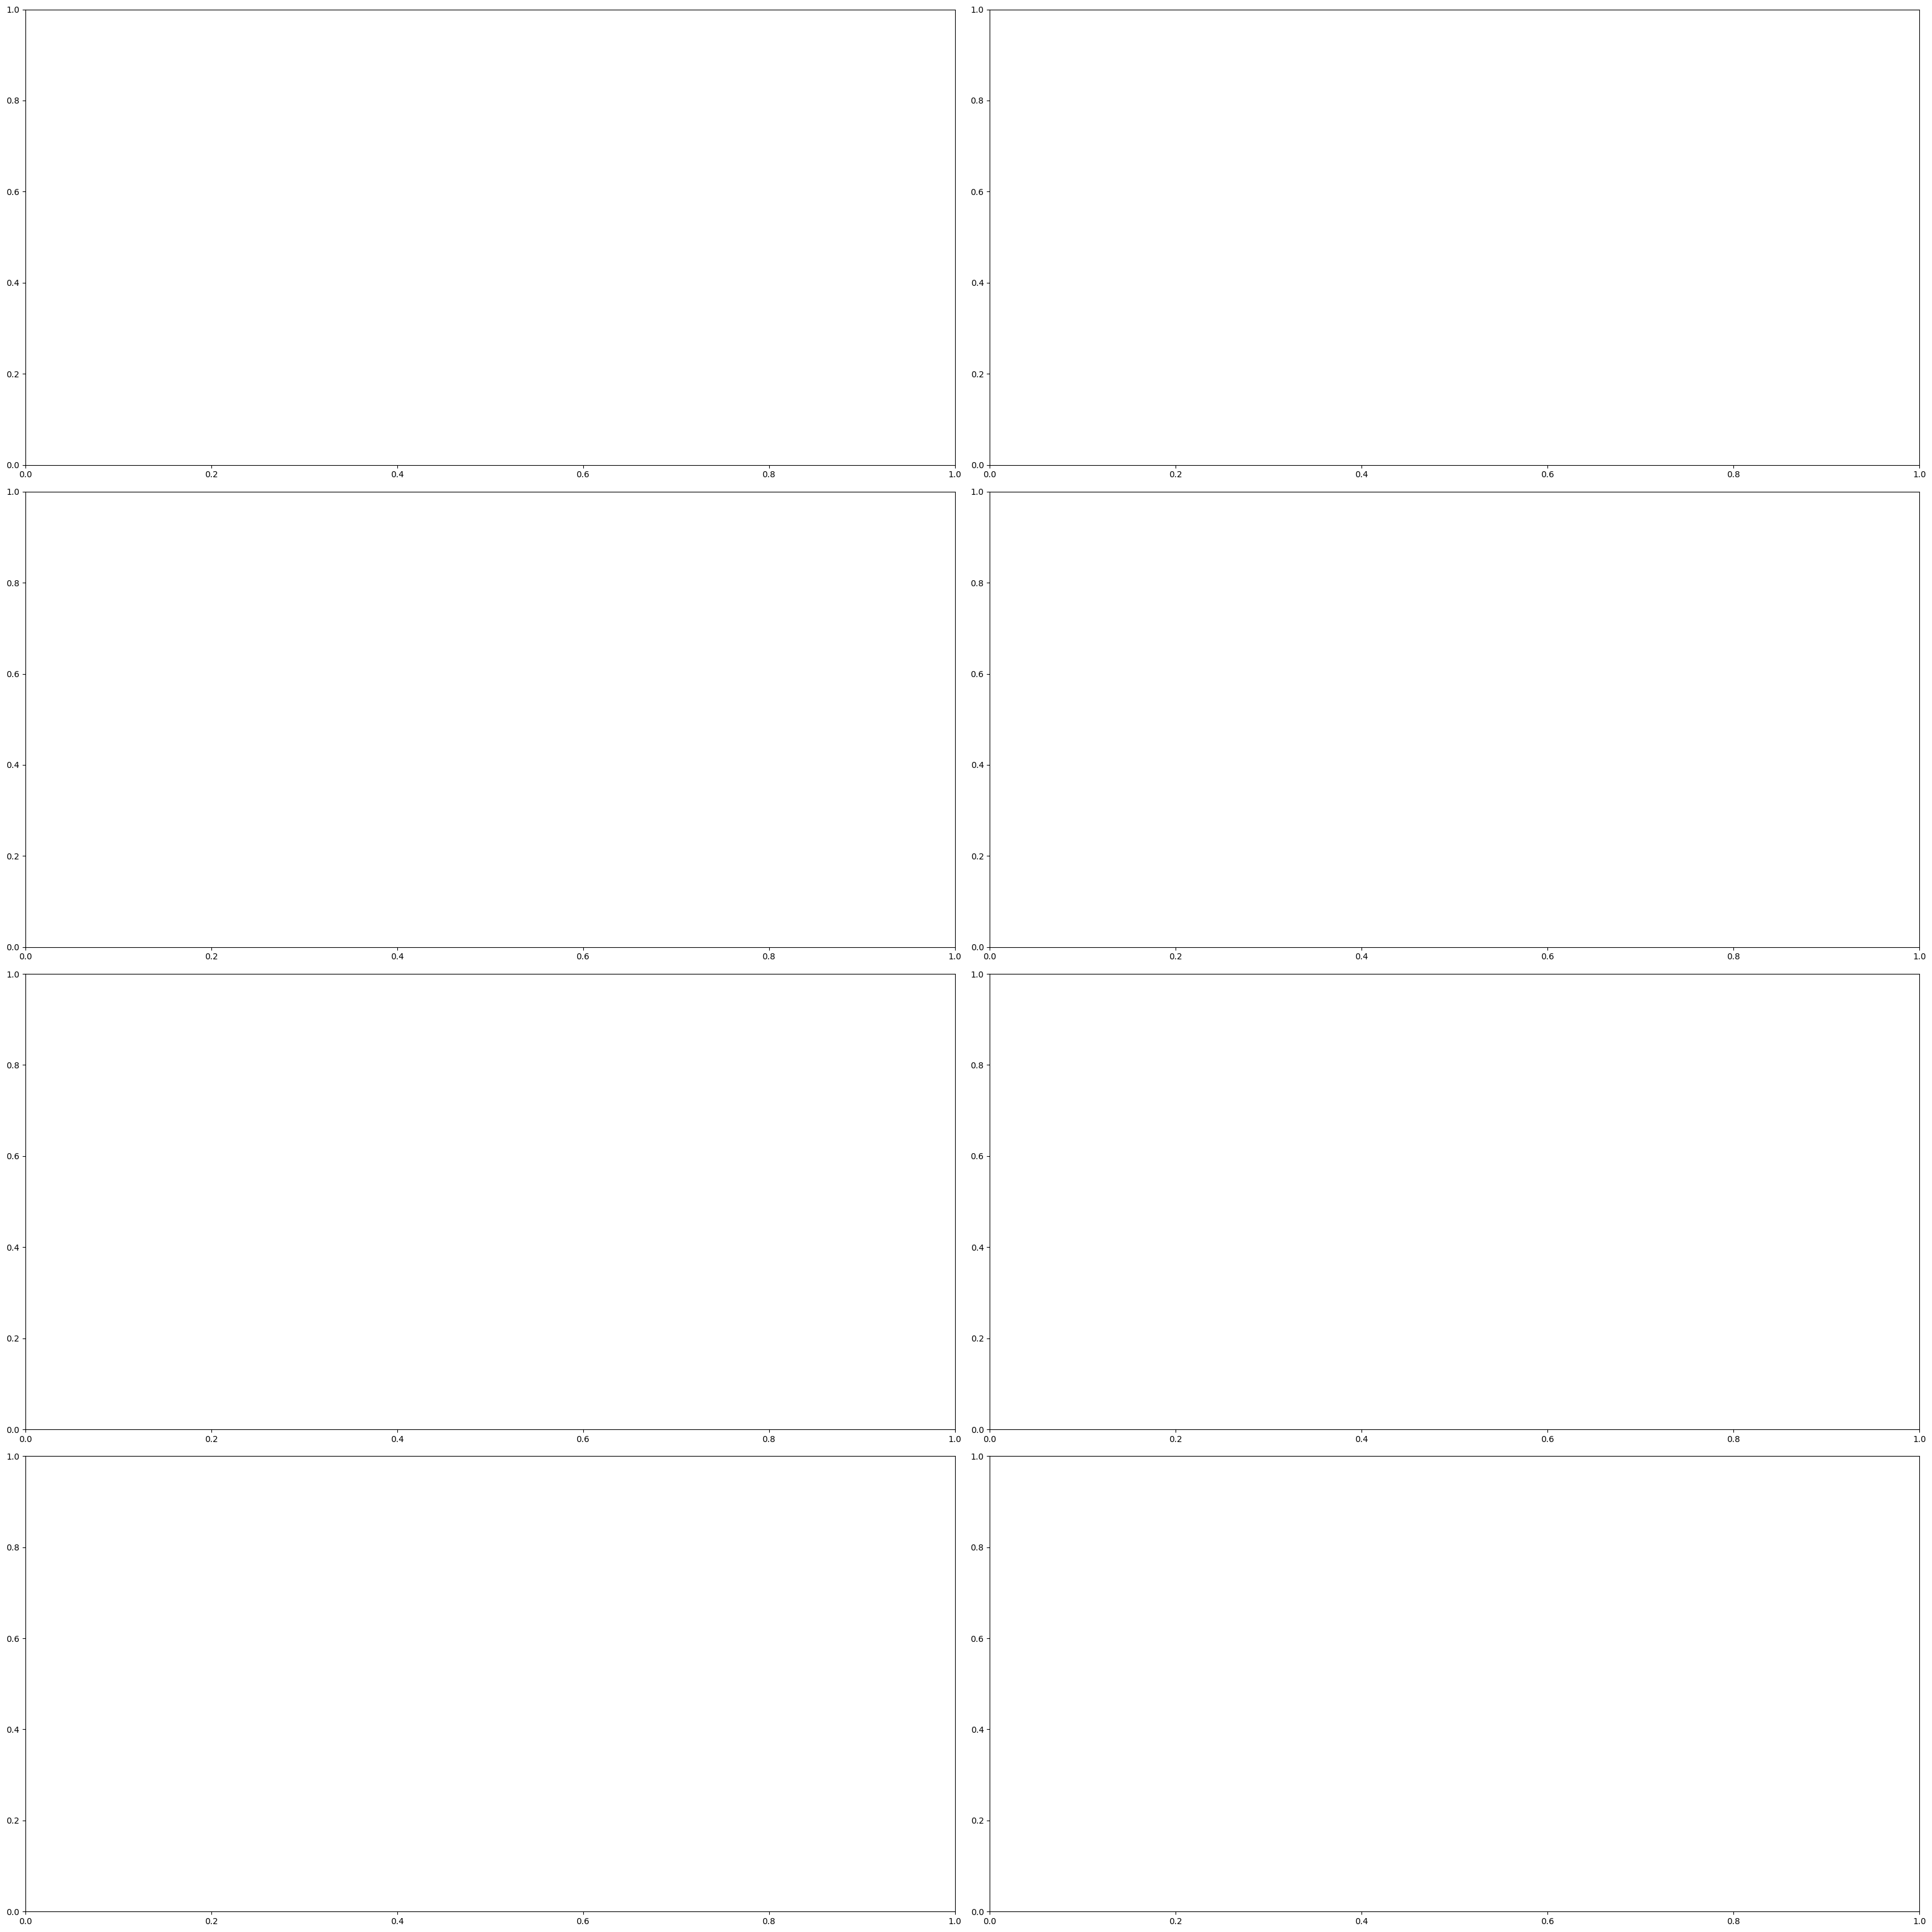

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(4, 2, figsize=(32, 32))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))

for ax, (step, color) in zip(axes, zip(steps, colors)):
    color = "blue"
    ax.set_xscale("symlog")

    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = error_lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            ax.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    xs = np.array(xs)

    # Smooth means and stds with gaussian filter
    # means = gaussian_filter1d(means, sigma=1.0)
    # stds = gaussian_filter1d(stds, sigma=1.0)

    # Plot mean line and std area
    ax.plot(xs, means, "-", label=f"step={step}", color=color, lw=1)
    # ax.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

    ax.set_xticks(ws)
    ax.set_xticklabels([str(w) for w in ws])
    ax.set_title(f"step={step}")
    ax.set_xlabel("denoising window")
    ax.set_ylabel("median error")
    ax.set_ylim(0.0, 0.5)

plt.tight_layout()
plt.show()


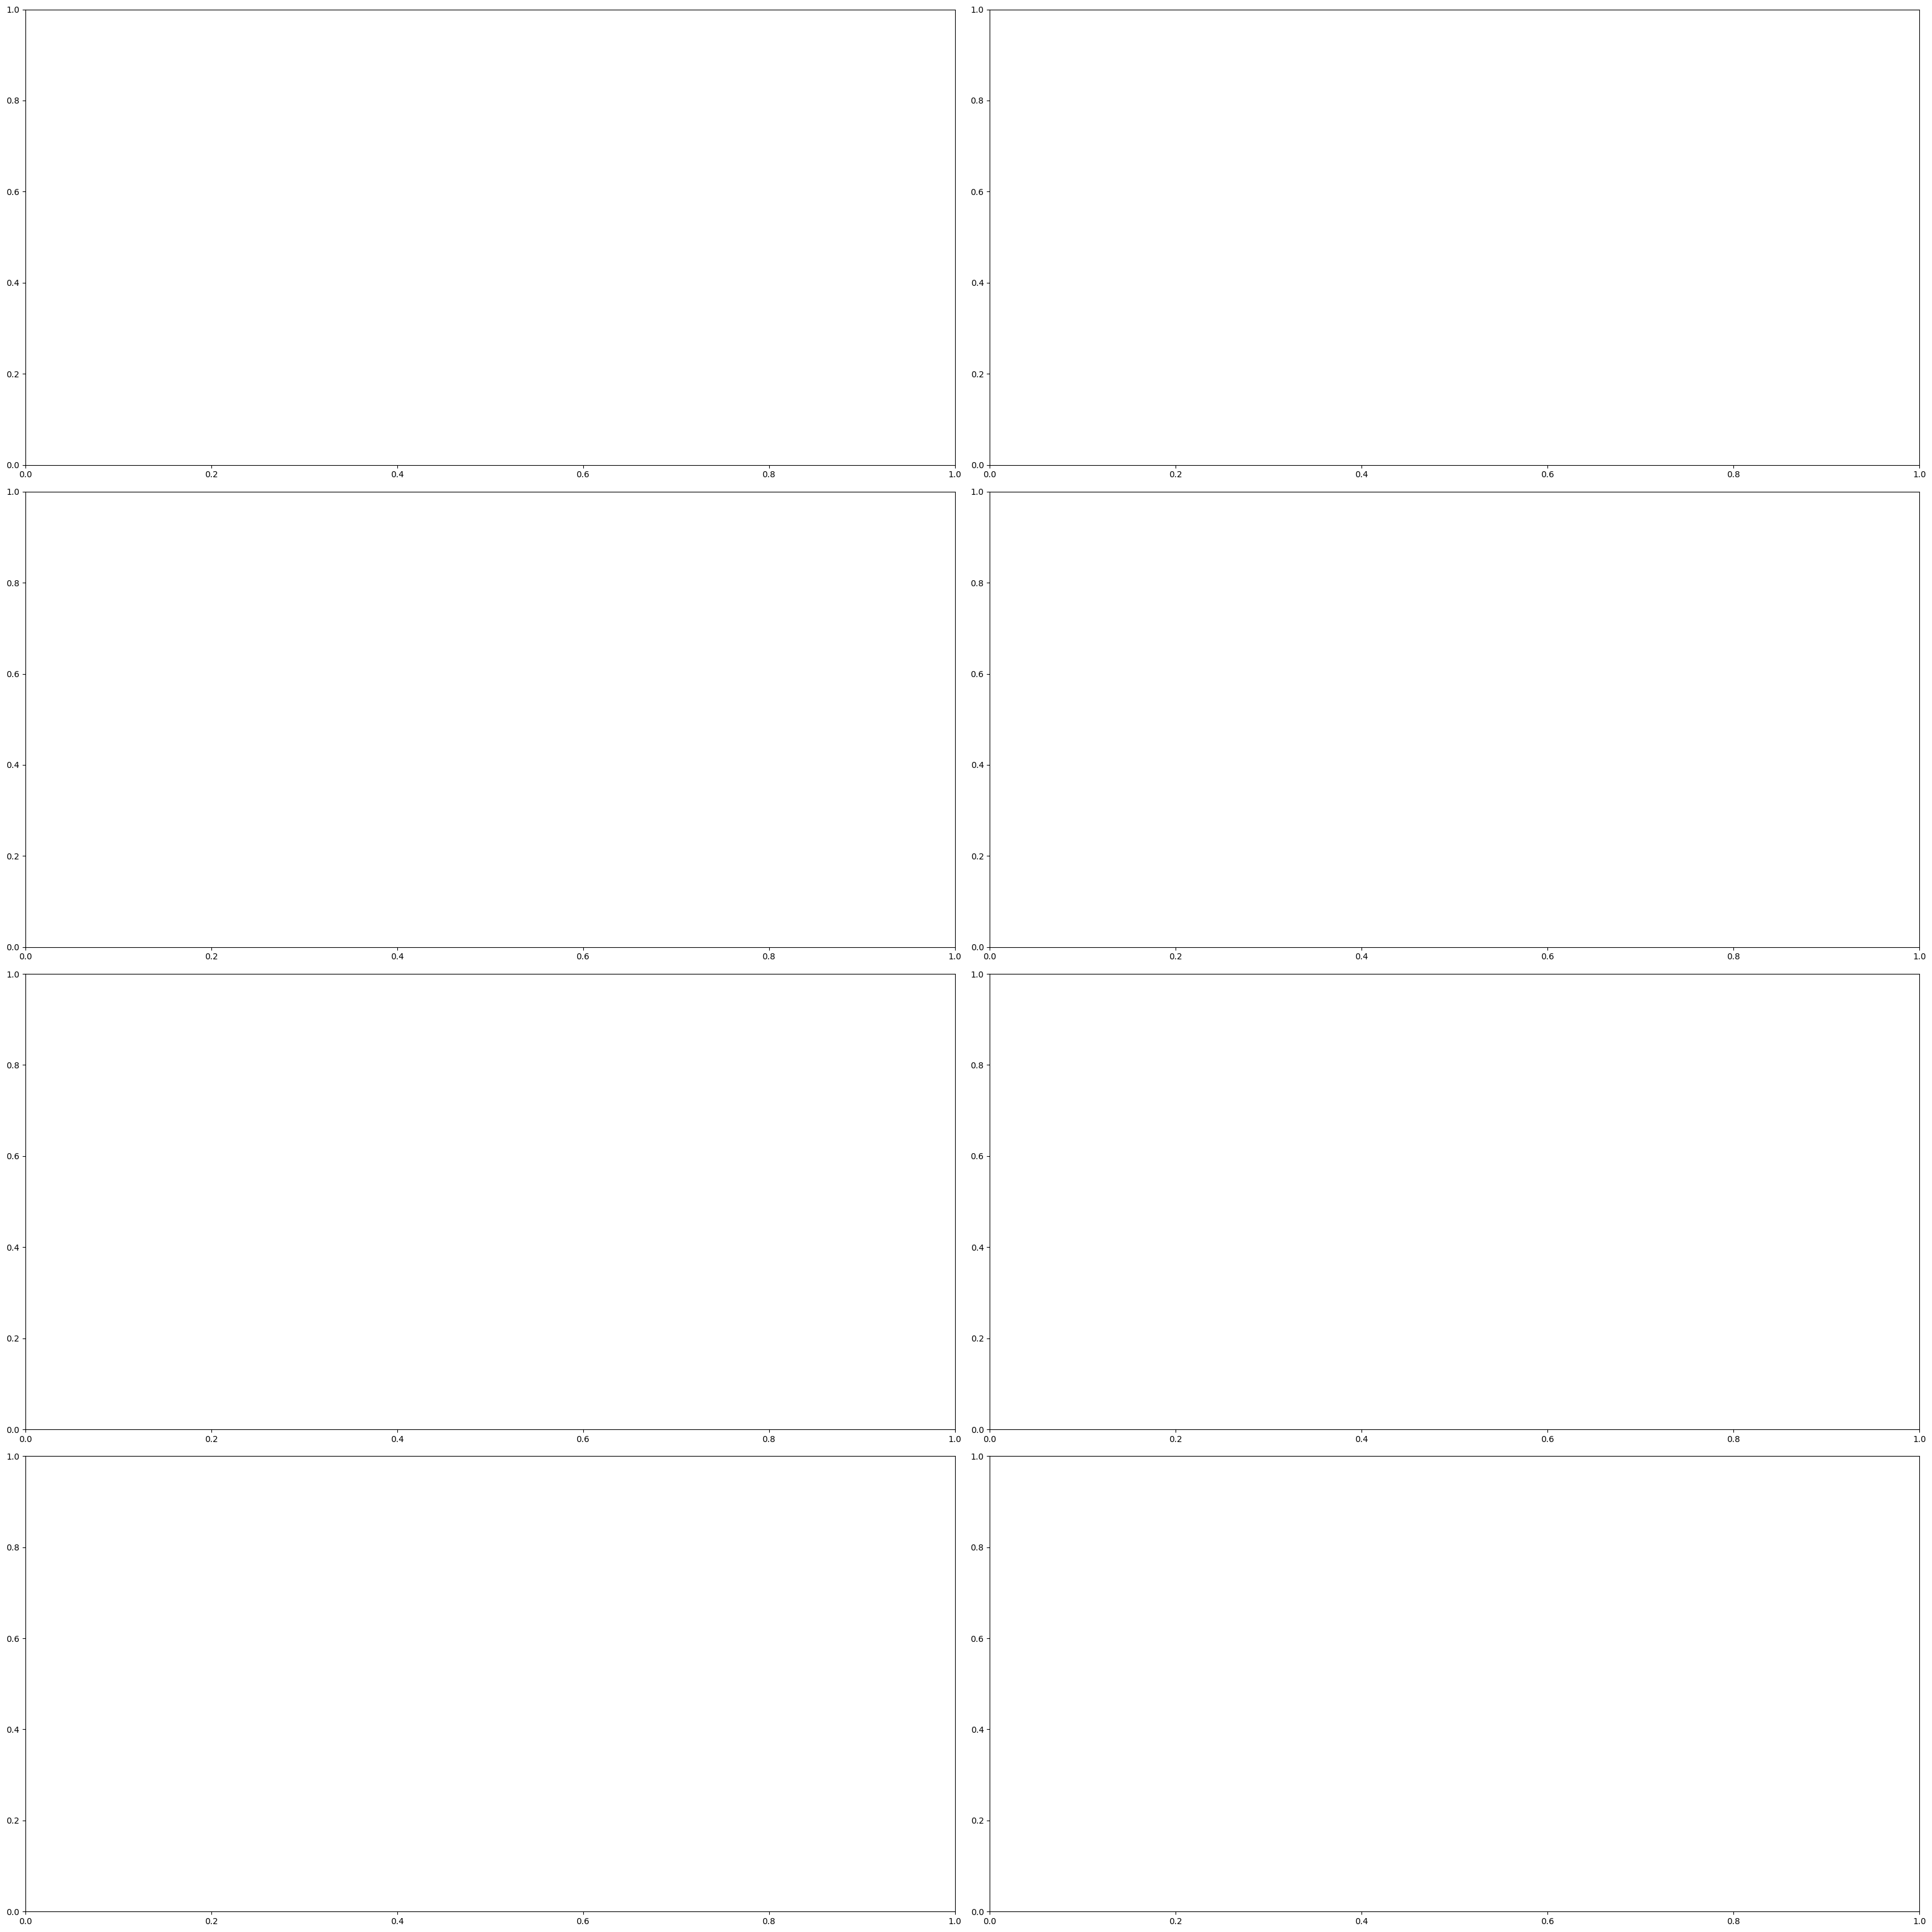

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(4, 2, figsize=(32, 32))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))

for ax, (step, color) in zip(axes, zip(steps, colors)):
    color = "green"
    ax.set_xscale("log")

    # Collect and compute statistics for each window size
    means, stds, xs = [], [], []
    for w in ws:
        cur = loss_lists[(step, w)]
        if len(cur) > 0:
            means.append(np.median(cur))
            stds.append(np.std(cur))
            xs.append(w)
            ax.plot([w] * len(cur), cur, "o", ms=3, alpha=0.5, color=color)

    if len(xs) == 0:
        continue

    # Convert to arrays
    xs = np.array(xs)
    means = np.array(means)
    stds = np.array(stds)

    # Smooth means and stds with gaussian filter
    means = gaussian_filter1d(means, sigma=1.0)
    stds = gaussian_filter1d(stds, sigma=1.0)

    # Plot mean line and std area
    ax.plot(xs, means, "-", label=f"step={step}", color=color, lw=1)
    # ax.fill_between(xs, means - stds, means + stds, alpha=0.05, color=color)

    ax.set_xticks(ws)
    ax.set_xticklabels([str(w) for w in ws])
    ax.set_title(f"step={step}")
    ax.set_xlabel("denoising window")
    ax.set_ylabel("loss")
    ax.set_ylim(50.0, 150.0)

plt.tight_layout()
plt.show()


/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter kernel__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


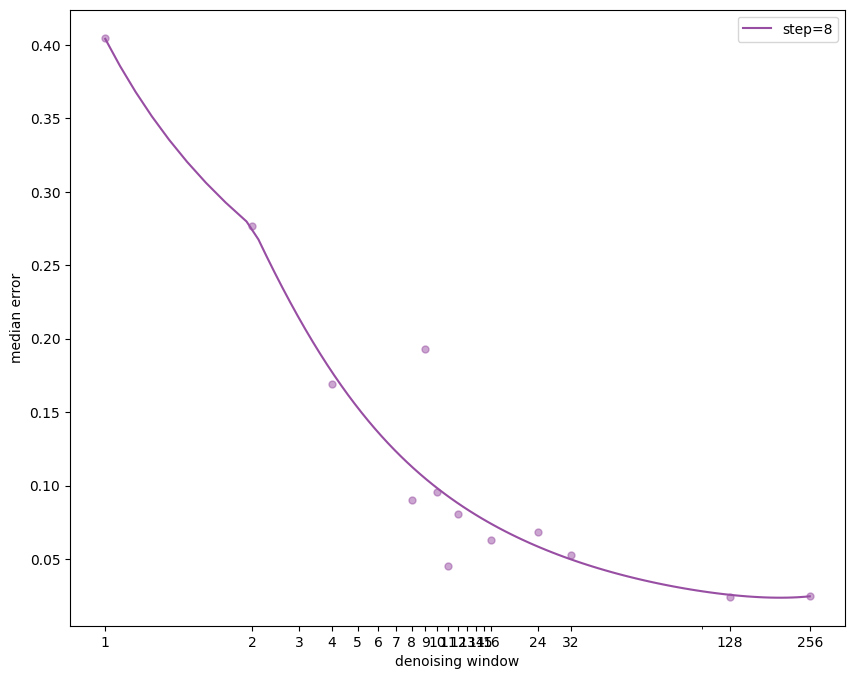

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

plt.figure(figsize=(10, 8))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in error_lists])))
steps = sorted(list(set([step for (step, w) in error_lists])))
colors = plt.cm.Set1(np.linspace(0.3, 0.7, len(steps)))
steps = [6, 8, 10]

for step, color in zip(steps, colors):
    # Collect data points for each window size
    points_x, points_y = [], []
    for w in ws:
        cur = error_lists[(step, w)]
        cur = [x for x in cur if x < 2]
        if len(cur) > 0:
            points_x.extend([np.log1p(w)] * len(cur))
            points_y.extend(cur)
            plt.plot([w] * len(cur), cur, "o", ms=5, alpha=0.5, color=color)

    if len(points_x) == 0:
        continue

    # Convert to arrays and reshape for GP
    X = np.array(points_x).reshape(-1, 1)
    y = np.array(points_y)

    # Define kernel as sum of RBF and WhiteNoise
    l, r = 5.0, 10.0
    kernel = (
        RBF(length_scale=(l * r) ** 0.5, length_scale_bounds=(l, r)) ** 0.5
    )  # + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1.0))

    # Fit Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(X, y)

    # Predict on fine grid for smooth curve
    X_pred = np.linspace(np.log1p(min(ws)), np.log1p(max(ws)), 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    # Plot GP mean and confidence interval
    plt.plot(np.expm1(X_pred), y_pred, "-", label=f"step={step}", color=color)
    plt.fill_between(
        np.expm1(X_pred).ravel(),
        y_pred - 2 * sigma,
        y_pred + 2 * sigma,
        alpha=0.05,
        color=color,
    )

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()
